### Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
from neuropy.analyses import NeuronEnsembles
import subjects

### Plotting activation of ensembles in an example session

In [ ]:
sess = subjects.sd.ratUday4[0]

In [ ]:
neurons = sess.neurons.get_neuron_type('pyr')
pre = sess.paradigm['pre']
maze = sess.paradigm['maze']
re_maze= sess.paradigm['re-maze']
post = sess.paradigm['post']

maze_ensembles =  NeuronEnsembles(neurons,maze[0],maze[1],bin_size=0.25)
maze_ensembles.calculate_activation(pre[0],pre[1])
mean_pre_activation = np.mean(maze_ensembles.activation,axis=1,keepdims=True)
maze_ensembles.calculate_activation(post[0],re_maze[1])

In [ ]:
%matplotlib widget

maze_ensembles.plot_activation()
# plt.plot(np.mean(maze_ensembles.activation-mean_pre_activation,axis=0))

In [ ]:
%matplotlib widget
from scipy import stats
a = maze_ensembles.weights 
a_zsc = stats.zscore(a,axis=0) 
a_sig_logical = np.where(a_zsc>1.5,1,0)
b = np.sort(a_sig_logical,axis=0)
# maze_ensembles.plot_ensembles()
c = np.lexsort(a_sig_logical.T)
a_new = a[c,:]
plt.pcolormesh(a_new)

### Average activation during SD vs NSD

In [2]:
sessions = subjects.pf_sess()

In [ ]:
maze_react = []
for s, sess in enumerate(sessions):
    neurons = sess.neurons.get_neuron_type("pyr")
    pre = sess.paradigm["pre"].flatten()
    maze = sess.paradigm["maze"].flatten()
    post = sess.paradigm["post"].flatten()
    neurons = sess.neurons_stable.get_neuron_type("pyr")

    zts = np.array([0, 2.5, 5])
    zt_starts = zts * 3600 + post[0]
    zt_stops = zt_starts + 2.5 * 3600
    zt_epochs = np.vstack((zt_starts, zt_stops)).T

    maze_ensembles = NeuronEnsembles(neurons, maze[0], maze[1])
    n_ensembles = maze_ensembles.n_ensembles
    pre_act = maze_ensembles.get_activation(*pre)[0].mean(axis=1)[:,np.newaxis]

    zt_acts = np.zeros(3)
    for i, e in enumerate(zt_epochs):
        act = maze_ensembles.get_activation(*e)[0]-pre_act
        # act = np.where(act>0,act,0)
        zt_acts[i] = act.mean()

    # zt_react = zt_acts - pre_act[:, np.newaxis]
    df = pd.DataFrame(
        dict(
            zt=["0.0-2.5", "2.5-5.0", "5.0-7.5"],
            react=zt_acts,
            s=s,
            grp=sess.tag,
        )
    )
    maze_react.append(df)

maze_react = pd.concat(maze_react,ignore_index=True)

In [ ]:
act = maze_ensembles.get_activation(*zt_epochs[0])[0]

In [ ]:
_,ax = plt.subplots()

ax.plot(act[3])

In [ ]:
_,ax= plt.subplots()

sns.barplot(data=maze_react,x='zt',y='react',hue='grp')

### Distribution of activation strength comparision between SD vs NSD

In [5]:
sessions = subjects.pf_sess()
maze_react = []
for s, sess in enumerate(sessions):
    neurons = sess.neurons.get_neuron_type("pyr")
    pre = sess.paradigm["pre"].flatten()
    maze = sess.paradigm["maze"].flatten()
    post = sess.paradigm["post"].flatten()
    neurons = sess.neurons_stable.get_neuron_type("pyr")

    epochs = sess.get_zt_epochs(include_maze=False)

    maze_ensembles = NeuronEnsembles(neurons, maze[0], maze[1])
    n_ensembles = maze_ensembles.n_ensembles
    pre_act = maze_ensembles.get_activation(*pre)[0].mean(axis=1)[:, np.newaxis]

    for e in epochs.itertuples():
        act = maze_ensembles.get_activation(e.start,e.stop)[0] - pre_act

        df = pd.DataFrame(
            dict(
                zt=e.label,
                react=act.mean(axis=0),
                session=s,
                grp=sess.tag,
            )
        )

        maze_react.append(df)

maze_react = pd.concat(maze_react, ignore_index=True)


<AxesSubplot:xlabel='zt', ylabel='react'>

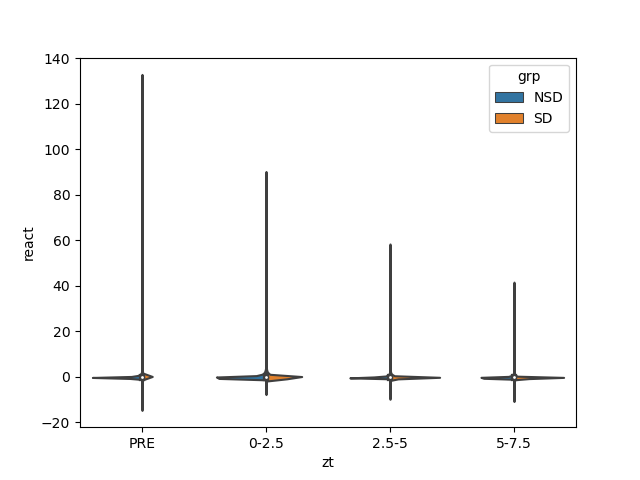

In [10]:
_,ax = plt.subplots()

sns.violinplot(data=maze_react,x='zt',y='react',hue='grp',split=True)

### Comparing MAZE ensembles and last 2 hours of SD
- Found no difference between SD and NSD. Probably it makes sense because ICA ensembles will across different periods involves the same set of neurons and because it forces each ensemble to be independent of each other, naturally the correlations will have similar distributions. Nothing interesting here. 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from neuropy.analyses import NeuronEnsembles
import subjects

sd_sessions = subjects.sd.ratNday1+subjects.sd.ratSday3 + subjects.sd.ratUday4
nsd_sessions = subjects.nsd.ratNday2+subjects.nsd.ratSday2 + subjects.nsd.ratUday2

In [ ]:
sd_ensembles_corr = []
for sess in sd_sessions:
    neurons = sess.neurons.get_neuron_type('pyr')
    pre = sess.paradigm['pre']
    maze = sess.paradigm['maze']
    re_maze= sess.paradigm['re-maze']
    post = sess.paradigm['post']
    # sd= sess.paradigm['sd']
    sd = [post[0],post[0]+5*3600]


    maze_ensembles =  NeuronEnsembles(neurons,maze[0],maze[1],bin_size=0.25)
    sd_ensembles =  NeuronEnsembles(neurons,sd[0]+3*3600,sd[1],bin_size=0.25)

    maze_weights =np.zeros((neurons.n_neurons,maze_ensembles.n_ensembles)) 
    sd_weights =np.zeros((neurons.n_neurons,sd_ensembles.n_ensembles)) 

    maze_indx= np.isin(neurons.neuron_ids,maze_ensembles.neurons.neuron_ids)
    sd_indx= np.isin(neurons.neuron_ids,sd_ensembles.neurons.neuron_ids)

    maze_weights[maze_indx] = maze_ensembles.weights
    sd_weights[sd_indx] = sd_ensembles.weights

    combined_weights = np.hstack((maze_weights,sd_weights))
    l = combined_weights.shape[1]//2
    # corr = np.corrcoef(combined_weights.T)[l:,:l]
    corr = np.corrcoef(combined_weights.T)[maze_ensembles.n_ensembles:,:maze_ensembles.n_ensembles]


    sd_ensembles_corr.append(corr.reshape(-1))

nsd_ensembles_corr = []
for sess in nsd_sessions:
    neurons = sess.neurons.get_neuron_type('pyr')
    pre = sess.paradigm['pre']
    maze = sess.paradigm['maze']
    re_maze= sess.paradigm['re-maze']
    post = sess.paradigm['post']
    # sd= sess.paradigm['sd']
    sd = [post[0],post[0]+5*3600]


    maze_ensembles =  NeuronEnsembles(neurons,maze[0],maze[1],bin_size=0.25)
    sd_ensembles =  NeuronEnsembles(neurons,sd[0]+3*3600,sd[1],bin_size=0.25)

    maze_weights =np.zeros((neurons.n_neurons,maze_ensembles.n_ensembles)) 
    sd_weights =np.zeros((neurons.n_neurons,sd_ensembles.n_ensembles)) 

    maze_indx= np.isin(neurons.neuron_ids,maze_ensembles.neurons.neuron_ids)
    sd_indx= np.isin(neurons.neuron_ids,sd_ensembles.neurons.neuron_ids)

    maze_weights[maze_indx] = maze_ensembles.weights
    sd_weights[sd_indx] = sd_ensembles.weights

    combined_weights = np.hstack((maze_weights,sd_weights))
    l = combined_weights.shape[1]//2
    corr = np.corrcoef(combined_weights.T)[maze_ensembles.n_ensembles:,:maze_ensembles.n_ensembles]
    
    nsd_ensembles_corr.append(corr.reshape(-1))

sd_ensembles_corr = np.concatenate(sd_ensembles_corr)
nsd_ensembles_corr = np.concatenate(nsd_ensembles_corr)


In [ ]:
%matplotlib inline
from neuropy.plotting import Fig
from neuropy.utils import mathutil

_,axes = plt.subplots(1,1)
# axes = axes.reshape(-1)
# for i,corr in enumerate():
#     np.fill_diagonal(corr,0)
#     axes[i].pcolormesh(corr,vmax=0.3,vmin=-0.3,cmap='jet')
colors = ['r','k']
bins = np.arange(-0.3,0.3,0.001)
for i,corr_vals in enumerate([sd_ensembles_corr,nsd_ensembles_corr]):

    cdf = mathutil.cdf(corr_vals,bins)
    axes.plot(bins[:-1],cdf,color = colors[i])
    Fig.remove_spines(axes)
    Fig.set_spines_width(axes) 

axes.set_xlabel('Correlation')
axes.set_ylabel('CDF')
axes.legend(['SD','NSD'])
axes.set_title('Correlation of ensembles: MAZE vs ZT(3 to 5)')

### Neurons participating in MAZE-enembles, how does their firing rate change during SD

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from neuropy import plotting
import pandas as pd
from scipy import stats
from neuropy.analyses import NeuronEnsembles
import subjects

sessions = (
    subjects.sd.ratNday1
    + subjects.sd.ratSday3
    + subjects.sd.ratUday4

    + subjects.nsd.ratNday2
    + subjects.nsd.ratSday2
    + subjects.nsd.ratUday2
)

In [ ]:
for sub,sess in enumerate(sessions):
    maze = sess.paradigm['maze'].flatten()
    post = sess.paradigm['post'].flatten()
    neurons = sess.neurons.get_neuron_type('pyr')
    ensembles = NeuronEnsembles(neurons,maze[0],maze[1],bin_size=0.25,frate_thresh=0)
    zsc_weights = stats.zscore(ensembles.weights,axis=0)
    zsc_thresh= np.where(zsc_weights>2)
    

### Maze ensembles activity on remaze

In [ ]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import subjects

sessions = subjects.nsd.remaze + subjects.sd.remaze

In [ ]:
from neuropy.analyses import NeuronEnsembles
import pingouin as pg
from neuropy.utils.neurons_util import calculate_neurons_ccg

reactivation_df = []
for sub, sess in enumerate(tqdm(sessions)):
    pre = sess.paradigm["pre"].flatten()
    maze = sess.paradigm["maze"].flatten()
    remaze = sess.paradigm["re-maze"].flatten()

    neurons = sess.neurons.get_neuron_type("pyr")
    wave_similarity = neurons.get_waveform_similarity()
    pairs_bool = wave_similarity < 0.8  # only pairs which are least similar

    maze_ensembles = NeuronEnsembles(neurons,t_start=maze[0],t_stop=maze[1])
    maze_ensembles.calculate_activation(*remaze)
    
    remaze_activation = np.mean(maze_ensembles.activation)

    reactivation_df.append(
        pd.DataFrame(
            dict(t='remaze',activation=[remaze_activation], grp=sess.tag)
        )
    )


reactivation_df = pd.concat(reactivation_df, ignore_index=True)
subjects.GroupData().save(reactivation_df, "remaze_activation_of_maze")

In [ ]:
%matplotlib widget
import seaborn as sns

sns.barplot(data=reactivation_df,x='t',y='activation',hue='grp')

### Ensemble similarity between different epochs for remaze sessions
- epochs will be pre, maze, Zt0-5, Zt5-9, remaze

In [ ]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import subjects

sessions = subjects.nsd.remaze + subjects.sd.remaze

In [ ]:
from neuropy.analyses import NeuronEnsembles
import pingouin as pg
from neuropy.utils.neurons_util import calculate_neurons_ccg

ensemble_corr_sd, ensemble_corr_nsd = [], []
for sub, sess in enumerate(tqdm(sessions)):
    pre = sess.paradigm["pre"].flatten()
    maze = sess.paradigm["maze"].flatten()
    post = sess.paradigm["post"].flatten()
    remaze = sess.paradigm["re-maze"].flatten()
    zt0to5 = [post[0], post[0] + 5 * 3600]
    zt5to8 = [post[0] + 5 * 3600, post[0] + 8 * 3600]

    neurons = sess.neurons.get_neuron_type("pyr")
    epochs = [pre, maze, zt0to5, zt5to8, remaze]

    def _get_stable_neurons():
        frate = []
        for e in epochs:
            frate.append(neurons.time_slice(*e).firing_rate)

        frate = (np.asarray(frate).T > 0).sum(axis=1)
        return neurons[frate == 5]

    stbl_neurons = _get_stable_neurons()
    get_ensembles = lambda e: NeuronEnsembles(
        stbl_neurons, t_start=e[0], t_stop=e[1]
    ).weights

    weights = [get_ensembles(_) for _ in epochs]

    ensemble_sim = np.zeros((len(epochs), len(epochs)))
    for i1, w1 in enumerate(weights):
        for i2, w2 in enumerate(weights):
            corr = np.corrcoef(np.hstack((w1, w2)).T)
            ensemble_sim[i1, i2] = corr[w1.shape[1] :, : w1.shape[1]].mean()
    
    np.fill_diagonal(ensemble_sim,np.nan)

    if sess.tag == "SD":
        ensemble_corr_sd.append(ensemble_sim)

    if sess.tag == "NSD":
        ensemble_corr_nsd.append(ensemble_sim)

epoch_names = ['pre','maze','Zt0-5','Zt5-8','remaze']
ensemble_corr = dict(
    NSD=np.dstack(ensemble_corr_nsd).mean(axis=-1),
    SD=np.dstack(ensemble_corr_sd).mean(axis=-1),
    epoch_names = epoch_names,
)
subjects.GroupData().save(ensemble_corr, "remaze_ensemble_corr_across_sess")


In [ ]:
%matplotlib widget
import matplotlib.pyplot as plt

np.fill_diagonal(ensemble_sim,np.nan)
plt.imshow(ensemble_sim,cmap='jet')

### Ensemble activation between different epochs for remaze sessions
- Ensembles are detected in each of the epochs: pre, maze, Zt0-5, Zt5-9, remaze and their mean activation in remaining epochs

In [ ]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import subjects

sessions = subjects.nsd.remaze + subjects.sd.remaze

In [ ]:
from neuropy.analyses import NeuronEnsembles
from scipy import stats

ensemble_act_sd, ensemble_act_nsd = [], []
for sub, sess in enumerate(tqdm(sessions)):
    pre = sess.paradigm["pre"].flatten()
    maze = sess.paradigm["maze"].flatten()
    post = sess.paradigm["post"].flatten()
    remaze = sess.paradigm["re-maze"].flatten()
    zt0to5 = [post[0], post[0] + 5 * 3600]
    zt5to8 = [post[0] + 5 * 3600, post[0] + 8 * 3600]

    neurons = sess.neurons.get_neuron_type("pyr")
    epochs = [pre, maze, zt0to5, zt5to8, remaze]
    
    def _get_stable_neurons():
        frate = []
        for e in epochs:
            frate.append(neurons.time_slice(*e).firing_rate)

        frate = (np.asarray(frate).T > 0).sum(axis=1)
        return neurons[frate == 5]

    stbl_neurons = _get_stable_neurons()
    get_ensembles = lambda e: NeuronEnsembles(stbl_neurons, t_start=e[0], t_stop=e[1])

    ensembles = [get_ensembles(_) for _ in epochs]

    ensemble_act = np.zeros((len(epochs), len(epochs)))
    for i1,ensemble in enumerate(ensembles):
        for i2,epoch in enumerate(epochs):
            ensemble.calculate_activation(t_start=epoch[0],t_stop=epoch[1])
            zsc_activation = stats.zscore(ensemble.activation,axis=1) 
            zsc_thresh = np.where(zsc_activation>0,zsc_activation,0)
            ensemble_act[i1,i2] = np.mean(zsc_thresh)

    np.fill_diagonal(ensemble_act, np.nan)

    if sess.tag == "SD":
        ensemble_act_sd.append(ensemble_act)

    if sess.tag == "NSD":
        ensemble_act_nsd.append(ensemble_act)

epoch_names = ["pre", "maze", "Zt0-5", "Zt5-8", "remaze"]
ensemble_act_all = dict(
    NSD=np.dstack(ensemble_act_nsd).mean(axis=-1),
    SD=np.dstack(ensemble_act_sd).mean(axis=-1),
    epoch_names=epoch_names,
)
subjects.GroupData().save(ensemble_act_all, "remaze_ensemble_activation_across_sess")


In [ ]:
%matplotlib widget
import matplotlib.pyplot as plt

plt.plot(a)

### Ensemble transition matrix comparison between MAZE and POST-Sleep

In [ ]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import subjects

sessions = subjects.nsd.pf_sess+ subjects.sd.pf_sess

In [ ]:
from neuropy.analyses import NeuronEnsembles
from scipy import stats
from hmmlearn.hmm import GaussianHMM

transmat_sd_maze,transmat_sd_post,transmat_nsd_maze,transmat_nsd_post = [], [],[],[]
for sub, sess in enumerate(tqdm(sessions)):
    pre = sess.paradigm["pre"].flatten()
    maze = sess.paradigm["maze"].flatten()
    post = sess.paradigm["post"].flatten()
    remaze = sess.paradigm["re-maze"].flatten()
    zt0to5 = [post[0], post[0] + 5 * 3600]
    zt5to8 = [post[0] + 5 * 3600, post[0] + 8 * 3600]

    neurons = sess.neurons.get_neuron_type("pyr")
    epochs = [maze, zt0to5]

    # def _get_stable_neurons():
    #     frate = []
    #     for e in epochs:
    #         frate.append(neurons.time_slice(*e).firing_rate)

    #     frate = (np.asarray(frate).T > 0).sum(axis=1)
    #     return neurons[frate == 5]

    # stbl_neurons = _get_stable_neurons()
    get_ensembles = lambda e: NeuronEnsembles(neurons, t_start=e[0], t_stop=e[1])

    maze_ensembles = get_ensembles(maze)
    n_ensembles= maze_ensembles.n_ensembles
    maze_activation = maze_ensembles.calculate_activation(
        t_start=maze[0], t_stop=maze[1]
    )[0]
    zt0to5_activation = maze_ensembles.calculate_activation(
        t_start=zt0to5[0], t_stop=zt0to5[1]
    )[0]

    en_mat = np.arange(1,n_ensembles+1)[:,np.newaxis]
    maze_zsc_activation = stats.zscore(maze_activation,axis=1)
    maze_activation_thresh = np.where(maze_zsc_activation>0,1,0)
    maze_activation_thresh = maze_activation_thresh*en_mat

    zt0to5_zsc_activation = stats.zscore(zt0to5_activation,axis=1)
    zt0to5_activation_thresh = np.where(zt0to5_zsc_activation>0,1,0)
    zt0to5_activation_thresh =zt0to5_activation_thresh *en_mat 

    maze_model = GaussianHMM(n_components=n_ensembles,n_iter=100)
    maze_fit = maze_model.fit(maze_activation_thresh.T)
    sort_ind1 = np.argsort(np.sum(maze_model.means_,axis=1))
    maze_transmat = maze_model.transmat_[sort_ind1,:][:,sort_ind1]

    zt0to5_model = GaussianHMM(n_components=n_ensembles,n_iter=100)
    zt0to5_fit = zt0to5_model.fit(zt0to5_activation_thresh.T)
    sort_ind2 = np.argsort(np.sum(zt0to5_model.means_,axis=1))
    zt0to5_transmat = zt0to5_model.transmat_[sort_ind2,:][:,sort_ind2]

    if sess.tag =='NSD':
        transmat_nsd_maze.append(maze_transmat) 
        transmat_nsd_post.append(zt0to5_transmat) 

    if sess.tag =='SD':
        transmat_sd_maze.append(maze_transmat) 
        transmat_sd_post.append(zt0to5_transmat) 

In [ ]:
%matplotlib widget
import matplotlib.pyplot as plt

_,axs = plt.subplots(5,2)

for i,(m,p) in enumerate(zip(transmat_nsd_maze,transmat_nsd_post)):
    axs[i,0].pcolormesh(m,cmap='binary')
    axs[i,1].pcolormesh(p,cmap='binary')

### Ensemble CCG order compare between MAZE and POST-Sleep
- To assess if the ensembles themselves happen in a specific order and that order is preserved in the subsequent offline period.
- **Results**: did not find evidence of a strong temporal order at finer timescales (~10 ms), however there may be something at larger timescales(~250 ms binsize).

In [ ]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import subjects

sessions = subjects.nsd.pf_sess+ subjects.sd.pf_sess

In [ ]:
from neuropy.analyses import NeuronEnsembles
from scipy import stats
from neuropy.utils.ccg import correlograms

ccg_sd_maze,ccg_sd_post,ccg_nsd_maze,ccg_nsd_post = [], [],[],[]
for sub, sess in enumerate(tqdm(sessions)):
    pre = sess.paradigm["pre"].flatten()
    maze = sess.paradigm["maze"].flatten()
    post = sess.paradigm["post"].flatten()
    remaze = sess.paradigm["re-maze"].flatten()
    zt0to5 = [post[0], post[0] + 5 * 3600]
    zt5to8 = [post[0] + 5 * 3600, post[0] + 8 * 3600]

    neurons = sess.neurons.get_neuron_type("pyr")
    epochs = [maze, zt0to5]

    get_ensembles = lambda e: NeuronEnsembles(neurons, t_start=e[0], t_stop=e[1])

    maze_ensembles = get_ensembles(maze)
    n_ensembles= maze_ensembles.n_ensembles
    maze_activation,maze_t = maze_ensembles.calculate_activation(
        t_start=maze[0], t_stop=maze[1],bin_size=0.01
    )
    zt0to5_activation,zt0to5_t = maze_ensembles.calculate_activation(
        t_start=zt0to5[0], t_stop=zt0to5[1],bin_size=0.01
    )

    def get_ccg(time,act_mat):
        act_mat = stats.zscore(act_mat,axis=1)
        t,ids=[],[]
        for i,act in enumerate(act_mat):
            indices = np.where(act>1)[0]
            t.append(time[indices])
            ids.append(i*np.ones_like(indices))

        sort_ind = np.argsort(np.concatenate(t))
        t = np.concatenate(t)[sort_ind]
        ids = (np.concatenate(ids)[sort_ind]).astype('int')

        ccgs = correlograms(t,ids,sample_rate=100,bin_size=0.01,window_size=1)
        req_indx = np.tril_indices(act_mat.shape[0],k=-1)
        return stats.zscore(ccgs[req_indx[0],req_indx[1],:],axis=1)

    maze_ccg = get_ccg(maze_t,maze_activation)
    zt0to5_ccg = get_ccg(zt0to5_t,zt0to5_activation)

    sort_ind = np.argsort(np.argmax(maze_ccg,axis=1))
    maze_ccg = maze_ccg[sort_ind,:]
    zt0to5_ccg = zt0to5_ccg[sort_ind,:]


    if sess.tag =='NSD':
        ccg_nsd_maze.append(maze_ccg) 
        ccg_nsd_post.append(zt0to5_ccg) 

    if sess.tag =='SD':
        ccg_sd_maze.append(maze_ccg) 
        ccg_sd_post.append(zt0to5_ccg) 


In [ ]:
%matplotlib widget
import matplotlib.pyplot as plt

_,axs = plt.subplots(5,2)

for i,(m,p) in enumerate(zip(ccg_nsd_maze,ccg_nsd_post)):
    axs[i,0].pcolormesh(m,cmap='binary')
    axs[i,1].pcolormesh(p,cmap='binary')